In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nb
import os
import math
import cv2
from scipy.ndimage import zoom
import CMR_HFpEF_Analysis.data_simulation.transformation as transform
import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.Defaults as Defaults
import CMR_HFpEF_Analysis.Image_utils as util
import CMR_HFpEF_Analysis.sunny_brooks.functions_for_LAX as ff_LAX

2023-02-24 16:56:14.455370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


load manual segmentation

In [3]:
# load endo segmentation first
filepath = '/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks/LAX'
endo_file = os.path.join(filepath, 'contours/SC-N-02/4CH_endo.nii.gz')
endo = nb.load(endo_file).get_fdata()

# load epi segmentation
epi_file = os.path.join(filepath, 'contours/SC-N-02/4CH_epi.nii.gz')
epi = nb.load(epi_file).get_fdata()

gt = np.copy(epi)
gt[epi==1] = 2
gt[endo==1] = 1


# # find out which slice has segmentation
S = [i for i in range(0,endo.shape[-1]) if np.sum(endo[:,:,i]) > 0][0]
gt = gt[:,:, S]

# # move to center
gt, move = util.move_heart_center_to_image_center(gt,save_move_info = True)

# flip 
gt = np.flip(gt,1)

# dimension
gt = util.crop_or_pad(gt,[128,128])


# process
gt[:,84:] = 0  ############
gt[:,:0] = 0  ############
gt_slices = np.asarray([ii for ii in range(0,gt.shape[-1]) if np.sum(gt[:,ii]) > 0])
print('gt y:' ,gt_slices[0], gt_slices[-1], gt_slices.shape)

# gt_copy = np.copy(gt)
# gt_copy = zoom(gt_copy, [1.15,1] ,order = 0)  ############
# gt_copy_slices = np.asarray([ii for ii in range(0,gt_copy.shape[0]) if np.sum(gt_copy[ii,:]) > 0])
# gt = np.zeros(gt.shape)
# gt[gt_copy_slices[0]: gt_copy_slices[-1]+1, :] = gt_copy[gt_copy_slices[0]: gt_copy_slices[-1]+1, :]
# gt = util.move_heart_center_to_image_center(gt)

# # # x axis crop
# print('gt new x: ',np.asarray([ii for ii in range(0,gt.shape[0]) if np.sum(gt[ii,:]) > 0])[0], np.asarray([ii for ii in range(0,gt.shape[0]) if np.sum(gt[ii,:]) > 0])[-1])
# gt[:36, :] = 0  ############


gt y: 31 83 (53,)


load image

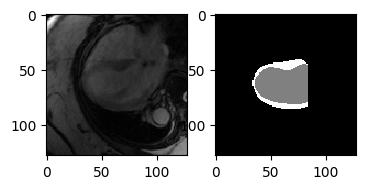

In [102]:
filepath = '/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks/LAX'
img_file = os.path.join(filepath, 'nii-images/SC-N-01/img-nii-rotated/4CH.nii.gz')
img = nb.load(img_file).get_fdata()

img = img[:,:,S]
img = util.move_3Dimage(img,move)
img = np.flip(img,1)
img = util.crop_or_pad(img,[128,128])

plt.figure(figsize = (4,2))
plt.subplot(121); plt.imshow(img, 'gray')
plt.subplot(122); plt.imshow(gt, 'gray')

find the boundary of segmentation

[0. 1. 2. 4. 6.]


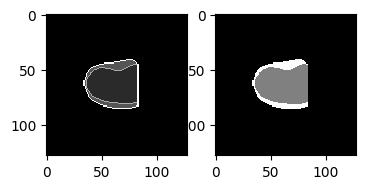

In [75]:
# endo-contour
lv = np.copy(gt); lv[lv!=1] = 0; 
lv_int = lv.astype(np.float64) / 1 # normalize the data to 0 - 1
lv_int = 255 * lv_int # Now scale by 255
lv_int = lv_int.astype(np.uint8)

contours, hierarchy = cv2.findContours(lv_int, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = np.copy(contours[0][:,0,:])

gt_contour = np.copy(gt)
for i in range(0,contours.shape[0]):
    gt_contour[contours[i][1], contours[i][0]] = 4

# epi-contour
lv = np.copy(gt); lv[lv!=0] = 1; 
lv_int = lv.astype(np.float64) / 1 # normalize the data to 0 - 1
lv_int = 255 * lv_int # Now scale by 255
lv_int = lv_int.astype(np.uint8)

contours, hierarchy = cv2.findContours(lv_int, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = np.copy(contours[0][:,0,:])

for i in range(0,contours.shape[0]):
    gt_contour[contours[i][1], contours[i][0]] = 6


plt.figure(figsize = (4,2))
plt.subplot(121); plt.imshow(gt_contour, 'gray')
plt.subplot(122); plt.imshow(gt, 'gray')
print(np.unique(gt_contour))

load prediction

In [8]:
# load case
main_path  = os.path.join('/mnt/mount_zc_NAS/HFpEF/predict/Sunny_Brooks/Iteration_C/round_1/images')
case_path = os.path.join(main_path, 'SC-N-02/tf1/pred_img_HR_final.nii.gz')
# main_path  = os.path.join('/mnt/mount_zc_NAS/HFpEF/predict/Sunny_Brooks/EDSR/images')
# case_path = os.path.join(main_path, 'SC-N-05/tf2/pred.nii.gz')
case = nb.load(case_path)
affine = case.affine
spacing = [1.3672, 1.3672, 1.6]
img = case.get_fdata()
img = np.round(img); img = img.astype(int)

# zoom to have the same dimension
img = zoom(img, [1,1,spacing[-1]/1.3672], order = 0)

# find Long-axis
original_apex_slice = 6   ############
original_base_slice = 53  ############
original_apex_mid, original_base_mid, L_list, x_list, y_list, base_point_list = ff_LAX.long_axis(img, original_apex_slice, original_base_slice, incre_unit = 3)
print(len(L_list))
# if len(L_list) >= 15:
#     original_apex_mid, original_base_mid, L_list, x_list, y_list, base_point_list = ff_LAX.long_axis(img, original_apex_slice, original_base_slice, incre_unit = 4)   
ii = 0   ############
L = L_list[ii]
x = x_list[ii]
y = y_list[ii]
print(L,x,y, original_apex_mid, original_base_mid)

img_new = ff_LAX.resample_img(img, original_apex_mid, L, x, y)

new_apex_slice = 11 ############
new_apex_mid = util.center_of_mass(img_new[:,:,new_apex_slice],0 ,large = True)
new_apex_mid = np.round(np.asarray([new_apex_mid[0], new_apex_mid[1], new_apex_slice])).astype(int)


20
[0. 0. 1.] [ 1.  0. -0.] [-0.  1.  0.] [57 56  6] [68 62 53]


best mean DICE:  0.9748538011695906 0.8302972195589645 0.9025755103642776


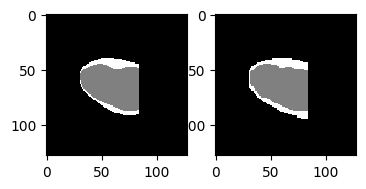

In [6]:
pred_pre_crop =  0 ########
apex_x = -2
apex_y = 2
r = -30
crop_base = 2

apex_m = new_apex_mid - np.asarray([apex_x, apex_y, 0])
translation,rotation,scale,M = transform.generate_transform_matrix([0,0,0],[0,0,r / 180 * np.pi],[1,1,1],img_new.shape)
M = transform.transform_full_matrix_offset_heart(M, np.array([apex_m[0], apex_m[1], img_new.shape[-1]//2]))
img_t = transform.apply_affine_transform(img_new, M, order = 0)

pred = img_t[apex_m[0],:,:]
pred = util.crop_or_pad(pred,[128,128])
pred = util.move_heart_center_to_image_center(pred)
heart_slice = np.asarray([ii for ii in range(0,pred.shape[1]) if np.sum(pred[:,ii]) > 0])

pred[:,(heart_slice[-1] - pred_pre_crop - crop_base):] = 0


pred_slices = np.asarray([ii for ii in range(0,pred.shape[-1]) if np.sum(pred[:,ii]) > 0])
pred_copy = np.copy(pred)
pred_copy = zoom(pred_copy, [1, gt_slices.shape[0] / pred_slices.shape[0]], order = 0)
pred_copy_slices = np.asarray([ii for ii in range(0,pred_copy.shape[-1]) if np.sum(pred_copy[:,ii]) > 0])
pred = np.zeros(pred.shape)
pred[:, pred_copy_slices[0]: pred_copy_slices[-1]+1] = pred_copy[:, pred_copy_slices[0]: pred_copy_slices[-1]+1]
pred_slices = np.asarray([ii for ii in range(0,pred.shape[-1]) if np.sum(pred[:,ii]) > 0])

move = [0, gt_slices[-1] - pred_slices[-1]]
pred = util.move_3Dimage(pred, move)

pred_mean_dice, ds, pred_for_dice = util.Dice_optim(pred, gt, [1,2], d = 5, threeDimage=False)
pred_mean_lv_dice = ff.np_categorical_dice(pred_for_dice, gt, 1)
pred_mean_myo_dice = ff.np_categorical_dice(pred_for_dice, gt, 2)
print('best mean DICE: ',pred_mean_lv_dice, pred_mean_myo_dice, pred_mean_dice)

plt.figure(figsize = (4,2))
plt.subplot(121); plt.imshow(gt, 'gray')
plt.subplot(122); plt.imshow(pred, 'gray')


find boundary for prediction

[0. 1. 2. 4. 6.]


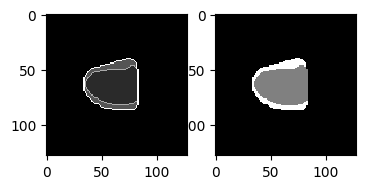

In [93]:
# endo-contour
lv = np.copy(pred); lv[lv!=1] = 0; 
lv_int = lv.astype(np.float64) / 1 # normalize the data to 0 - 1
lv_int = 255 * lv_int # Now scale by 255
lv_int = lv_int.astype(np.uint8)

contours, hierarchy = cv2.findContours(lv_int, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = np.copy(contours[0][:,0,:])

pred_contour = np.copy(pred)
for i in range(0,contours.shape[0]):
    pred_contour[contours[i][1], contours[i][0]] = 4

# epi-contour
lv = np.copy(pred); lv[lv!=0] = 1; 
lv_int = lv.astype(np.float64) / 1 # normalize the data to 0 - 1
lv_int = 255 * lv_int # Now scale by 255
lv_int = lv_int.astype(np.uint8)

contours, hierarchy = cv2.findContours(lv_int, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = np.copy(contours[0][:,0,:])

for i in range(0,contours.shape[0]):
    pred_contour[contours[i][1], contours[i][0]] = 6


plt.figure(figsize = (4,2))
plt.subplot(121); plt.imshow(pred_contour, 'gray')
plt.subplot(122); plt.imshow(pred, 'gray')
print(np.unique(pred_contour))


save

In [103]:
# ff.save_grayscale_image(gt_contour,os.path.join('/mnt/mount_zc_NAS/HFpEF/data','SC-N-05_gt_contours.png'),normalize = True)
# ff.save_grayscale_image(pred_contour, os.path.join('/mnt/mount_zc_NAS/HFpEF/data','SC-N-05_pred_EDSR_contours.png'),normalize = True)
ff.save_grayscale_image(img, os.path.join('/mnt/mount_zc_NAS/HFpEF/data','SC-N-05_4CH.png'),normalize = True)

make final images in matlab